In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

# Einlesen der Daten
Auffällig sind schon die fehlenden Werte (Nan)

In [47]:
df = pd.read_csv("../data/immo_data_202208_v2.csv", low_memory=False)
df.drop(["Unnamed: 0.1","Unnamed: 0"], axis=1,inplace=True) #Zwei Spalten für Index ?
df.head()

,Municipality,Living space,Plot area,Floor space,Availability,location,description,detailed_description,url,table,...,features,description_detailed,Floor space:,Number of floors:,Volume:,plz,Number of toilets:,Gross yield:,Minimum floor space:,space_cleaned
0,Biberstein,100 m²,NaN,NaN,On request,"5023 Biberstein, AG","3.5 rooms, 100 m²«Luxuriöse Attika-Wohnung mit...",DescriptionLuxuriöse Attika-Wohnung direkt an ...,https://www.immoscout24.ch//en/d/penthouse-buy...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
1,Biberstein,156 m²,222 m²,242 m²,On request,"Buhldenstrasse 8d5023 Biberstein, AG","4.5 rooms, 156 m²«Stilvolle Liegenschaft - ruh...",DescriptionStilvolle Liegenschaft an ruhiger L...,https://www.immoscout24.ch//en/d/terrace-house...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,"5022 Rombach, AG","2.5 rooms, 93 m²«Moderne, lichtdurchflutete At...","detail_responsive#description_title2,5 Zimmerw...",https://www.immoscout24.ch//en/d/penthouse-buy...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN,NaN,NaN
3,Biberstein,154 m²,370 m²,257 m²,On request,"Buhaldenstrasse 8A5023 Biberstein, AG","4.5 rooms, 154 m²«AgentSelly - Luxuriöses Eckh...",DescriptionDieses äusserst grosszügige Minergi...,https://www.immoscout24.ch//en/d/detached-hous...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
4,Küttigen,142 m²,NaN,NaN,On request,"5022 Rombach, AG","4.5 rooms, 142 m²«MIT GARTENSITZPLATZ UND VIEL...",DescriptionAus ehemals zwei Wohnungen wurde ei...,https://www.immoscout24.ch//en/d/flat-buy-romb...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN,NaN,NaN


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Columns: 132 entries, Municipality to space_cleaned
dtypes: float64(63), int64(2), object(67)
memory usage: 22.6+ MB


## Duplikate zählen

In [49]:
print(df.duplicated().sum())

0


Datensatz scheint keine Duplikate zu haben.

## Fehlende Daten zählen

### Insgesamt

In [50]:
print(df.isna().sum().sum())

1179856


Spalten mit den meisten fehlenden Werte

In [51]:
df.isna().sum().sort_values(ascending=False).head(10)

Minimum floor space:      22479
Superficie utile          22475
Gross return              22475
Piano                     22471
Superficie del terreno    22470
Surface utile             22467
Gross yield:              22467
Étage                     22457
Superficie abitabile      22454
Comune                    22454
dtype: int64

Spalten die komplett sind 

In [52]:
print((df.isna().sum() == 0).sum())

48


Im Vergleich zum ganzen Dataset

In [53]:
df.shape

(22481, 132)

**Zusammengefasst:** <br>
Es gibt sehr viele fehlende Werte. Wenn man die Spalten untersucht sieht man, dass es Spalten gibt wie "Minimum floor space:" welche 22479 fehlende Werte von 22481 hat. Es gibt aber auch 48 von 132 Spalten die keine fehlende Werte enthalten. <br>
Was mit den Spalten passiert, die so viele fehlende Werte haben wird in einem nächsten Schritt entschieden, da diese mit anderen Spalten kombiniert werden kann.


## Untersuchen von der Spalten

In [54]:
lst_columns = df.columns.tolist()
print(lst_columns)

['Municipality', 'Living space', 'Plot area', 'Floor space', 'Availability', 'location', 'description', 'detailed_description', 'url', 'table', 'Floor', 'detail_responsive#municipality', 'detail_responsive#surface_living', 'detail_responsive#floor', 'detail_responsive#available_from', 'Gemeinde', 'Wohnfläche', 'Stockwerk', 'Nutzfläche', 'Verfügbarkeit', 'Grundstücksfläche', 'detail_responsive#surface_property', 'detail_responsive#surface_usable', 'Commune', 'Surface habitable', 'Surface du terrain', 'Surface utile', 'Disponibilité', 'Étage', 'Comune', 'Superficie abitabile', 'Disponibilità', 'Gross return', 'Piano', 'Superficie del terreno', 'Superficie utile', 'Municipality_merged', 'Floor_merged', 'Living_space_merged', 'Floor_space_merged', 'Plot_area_merged', 'Availability_merged', 'location_parsed', 'title', 'details', 'address', 'price', 'link', 'details_structured', 'lat', 'lon', 'index', 'ForestDensityL', 'ForestDensityM', 'ForestDensityS', 'Latitude', 'Locality', 'Longitude', 

Wenn man die Namen der Spalten kurz überfliegt sieht bereits dass gewisse Spalten ähnliche oder Identische (bis auf : ) haben. Wir untersuchen diese um doppelte Spalten oder kombinierte Spalten zu entfernen.

### Gemeindenamen

In [55]:
df.corr(numeric_only=True)

,lat,lon,index,ForestDensityL,ForestDensityM,ForestDensityS,Latitude,Longitude,NoisePollutionRailwayL,NoisePollutionRailwayM,...,Plot_area_unified,Living_area_unified,No. of rooms:,Number of apartments:,Last refurbishment:,Year built:,Number of floors:,plz,Number of toilets:,space_cleaned
lat,1.000000,0.180147,-0.010526,-0.203306,-0.216668,-0.203569,0.999829,0.180193,0.083446,0.061792,...,-0.014735,-0.038911,0.070030,-0.024686,0.070865,-0.068486,0.047663,0.307753,NaN,0.034185
lon,0.180147,1.000000,-0.081788,0.264926,0.200145,0.126536,0.180773,0.999922,0.028920,0.026455,...,-0.044249,-0.078929,-0.188908,0.057026,0.027670,0.105591,0.034906,0.941211,NaN,-0.107655
index,-0.010526,-0.081788,1.000000,-0.147195,-0.151766,-0.126879,-0.011229,-0.082310,0.064940,0.105705,...,-0.008647,-0.042999,-0.070581,0.030306,0.034615,0.009944,0.025610,-0.102323,NaN,-0.027809
ForestDensityL,-0.203306,0.264926,-0.147195,1.000000,0.923260,0.768023,-0.203587,0.263742,-0.206917,-0.146290,...,-0.004377,-0.029173,-0.057368,-0.055964,-0.065418,-0.020098,0.000158,0.223951,NaN,-0.050534
ForestDensityM,-0.216668,0.200145,-0.151766,0.923260,1.000000,0.901304,-0.216391,0.199295,-0.190205,-0.146281,...,0.003575,-0.024360,-0.061261,-0.047144,-0.070379,-0.015201,0.005576,0.163482,NaN,-0.051093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year built:,-0.068486,0.105591,0.009944,-0.020098,-0.015201,-0.011974,-0.068453,0.105683,0.007066,-0.013164,...,-0.159976,-0.288329,-0.365799,0.063576,0.293508,1.000000,-0.130252,0.055200,NaN,-0.288358
Number of floors:,0.047663,0.034906,0.025610,0.000158,0.005576,0.008617,0.047285,0.034797,-0.037255,-0.047606,...,0.047995,0.113418,0.094016,0.367783,-0.063024,-0.130252,1.000000,0.078134,NaN,0.113316
plz,0.307753,0.941211,-0.102323,0.223951,0.163482,0.088860,0.308067,0.941262,0.015591,0.011815,...,-0.045500,-0.048474,-0.089699,0.043388,0.034623,0.055200,0.078134,1.000000,NaN,-0.044500
Number of toilets:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


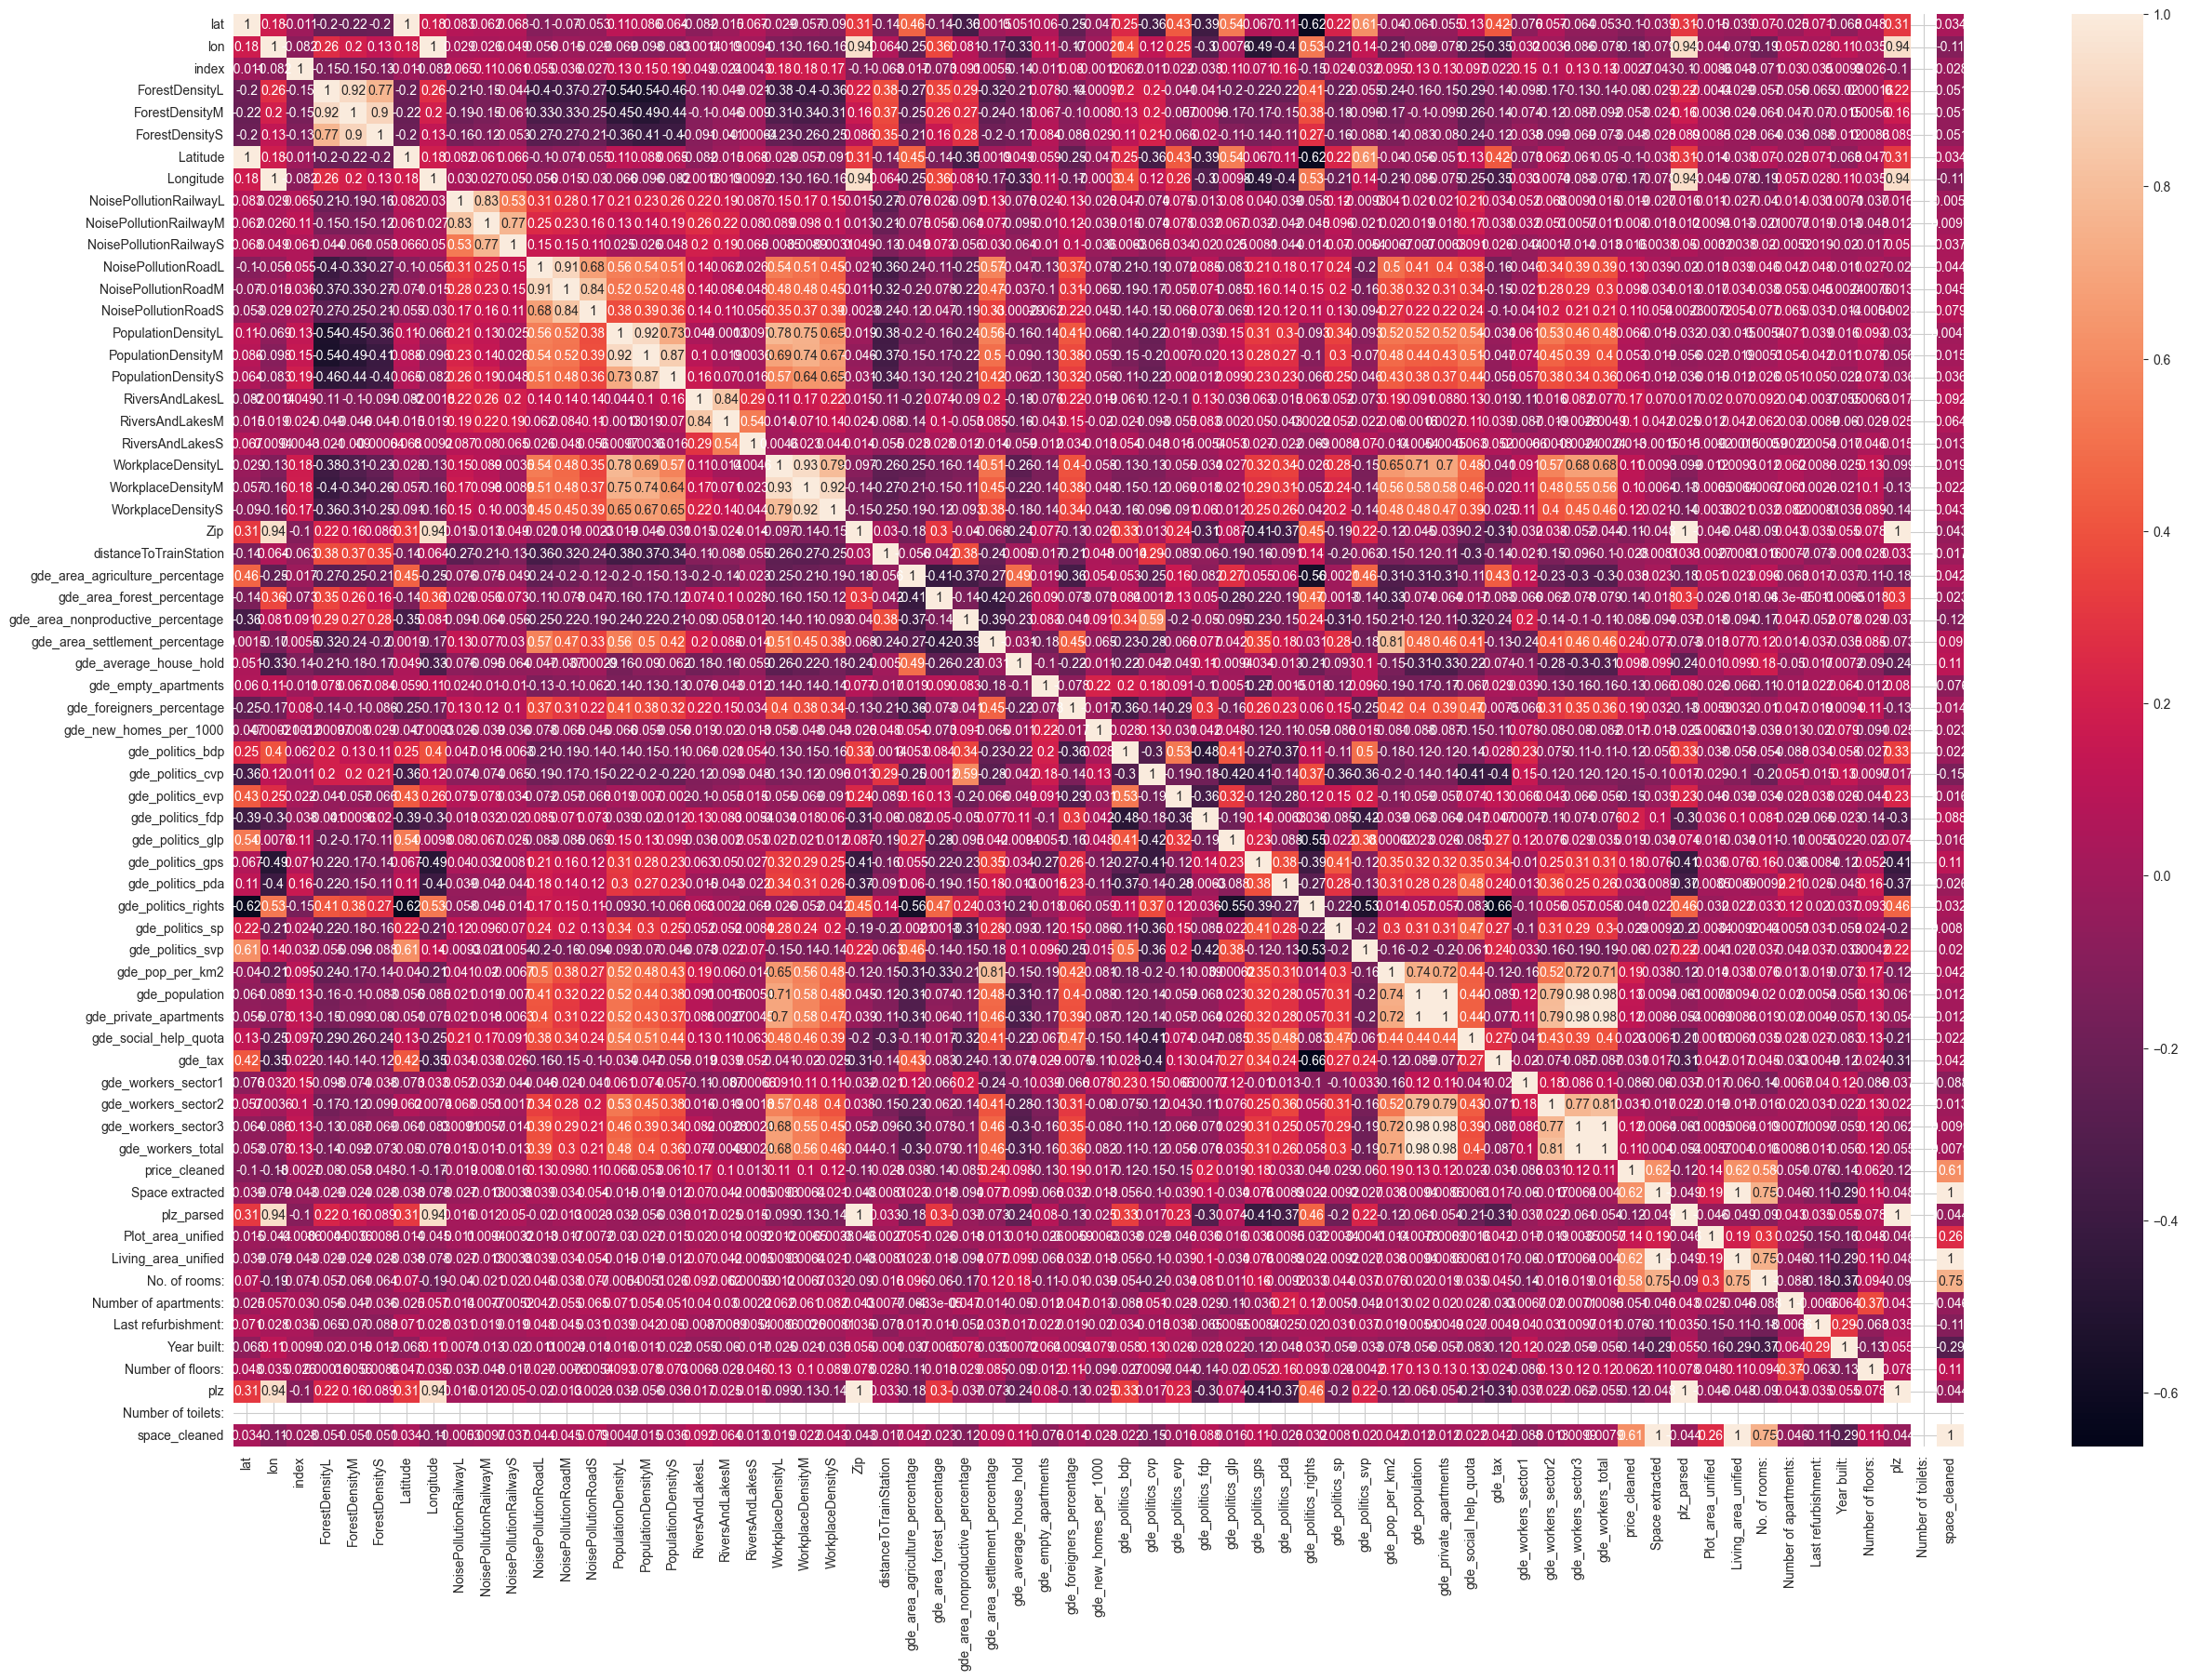

In [56]:
plt.subplots(figsize=(30,20))
ax = sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

## Untersuchen der Preissplaten

In [67]:
price_cols = df[["price","price_cleaned","price_s"]]
price_cols.head()

,price,price_cleaned,price_s
0,"CHF 1,150,000.—",1150000.0,NaN
1,"CHF 1,420,000.—",1420000.0,NaN
2,"CHF 720,000.—",720000.0,NaN
3,"CHF 1,430,000.—",1430000.0,NaN
4,"CHF 995,000.—",995000.0,NaN


In [58]:
price_cols.isna().sum()

price                0
price_cleaned     1015
price_s          13355
dtype: int64

In [59]:
price_cols[price_cols["price_cleaned"].isna()].head(10)

,price,price_cleaned,price_s
21,Price on request,NaN,NaN
27,Price on request,NaN,NaN
28,Price on request,NaN,NaN
29,Price on request,NaN,NaN
33,Price on request,NaN,NaN
43,Price on request,NaN,NaN
49,Price on request,NaN,NaN
56,Price on request,NaN,NaN
100,Price on request,NaN,NaN
105,Price on request,NaN,NaN


In [60]:
price_cols[~price_cols["price_s"].isna()].tail()

,price,price_cleaned,price_s
22476,"CHF475,000.–",475000.0,"CHF 475,000.–"
22477,"CHF1,490,000.–",1490000.0,"CHF 2,194,770.–"
22478,"CHF1,450,000.–",1450000.0,"CHF 2,135,850.–"
22479,"CHF1,290,000.–",1290000.0,"CHF 1,290,000.–"
22480,"CHF780,000.–",780000.0,"CHF 1,148,940.–"


In [69]:
df[df["price_s"] == "CHF 2,194,770.–"]

,Municipality,Living space,Plot area,Floor space,Availability,location,description,detailed_description,url,table,...,features,description_detailed,Floor space:,Number of floors:,Volume:,plz,Number of toilets:,Gross yield:,Minimum floor space:,space_cleaned
22477,Wil,NaN,NaN,NaN,NaN,"Fürstenlandstrasse 69, 9500 Wil",NaN,"Description\n""J'ADORE - Exklusives Wohnen in W...",https://www.homegate.ch/buy/3001826476,NaN,...,Balcony / Terrace\tWashing machine\tView\tWhee...,"Description\n""J'ADORE - Exklusives Wohnen in W...",NaN,3.0,NaN,9500.0,NaN,NaN,NaN,180.0


In [61]:
price_cols.replace("Price on request",np.nan, inplace=True)
price_cols.isna().sum()

C:\Users\wartm\AppData\Local\Temp\ipykernel_13156\323219152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_cols.replace("Price on request",np.nan, inplace=True)


price             1015
price_cleaned     1015
price_s          13355
dtype: int64

**Zusammengefasst:** <br>
price und price_cleaned scheinen identisch zu sein, der Sinn von price_s ist nicht bekannt.

## Untersuchen der Gemeinde Spalten + Postleitzahl

In [70]:
lst_columns

['Municipality',
 'Living space',
 'Plot area',
 'Floor space',
 'Availability',
 'location',
 'description',
 'detailed_description',
 'url',
 'table',
 'Floor',
 'detail_responsive#municipality',
 'detail_responsive#surface_living',
 'detail_responsive#floor',
 'detail_responsive#available_from',
 'Gemeinde',
 'Wohnfläche',
 'Stockwerk',
 'Nutzfläche',
 'Verfügbarkeit',
 'Grundstücksfläche',
 'detail_responsive#surface_property',
 'detail_responsive#surface_usable',
 'Commune',
 'Surface habitable',
 'Surface du terrain',
 'Surface utile',
 'Disponibilité',
 'Étage',
 'Comune',
 'Superficie abitabile',
 'Disponibilità',
 'Gross return',
 'Piano',
 'Superficie del terreno',
 'Superficie utile',
 'Municipality_merged',
 'Floor_merged',
 'Living_space_merged',
 'Floor_space_merged',
 'Plot_area_merged',
 'Availability_merged',
 'location_parsed',
 'title',
 'details',
 'address',
 'price',
 'link',
 'details_structured',
 'lat',
 'lon',
 'index',
 'ForestDensityL',
 'ForestDensityM',
 '

In [72]:
df.head()

,Municipality,Living space,Plot area,Floor space,Availability,location,description,detailed_description,url,table,...,features,description_detailed,Floor space:,Number of floors:,Volume:,plz,Number of toilets:,Gross yield:,Minimum floor space:,space_cleaned
0,Biberstein,100 m²,NaN,NaN,On request,"5023 Biberstein, AG","3.5 rooms, 100 m²«Luxuriöse Attika-Wohnung mit...",DescriptionLuxuriöse Attika-Wohnung direkt an ...,https://www.immoscout24.ch//en/d/penthouse-buy...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
1,Biberstein,156 m²,222 m²,242 m²,On request,"Buhldenstrasse 8d5023 Biberstein, AG","4.5 rooms, 156 m²«Stilvolle Liegenschaft - ruh...",DescriptionStilvolle Liegenschaft an ruhiger L...,https://www.immoscout24.ch//en/d/terrace-house...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,"5022 Rombach, AG","2.5 rooms, 93 m²«Moderne, lichtdurchflutete At...","detail_responsive#description_title2,5 Zimmerw...",https://www.immoscout24.ch//en/d/penthouse-buy...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN,NaN,NaN
3,Biberstein,154 m²,370 m²,257 m²,On request,"Buhaldenstrasse 8A5023 Biberstein, AG","4.5 rooms, 154 m²«AgentSelly - Luxuriöses Eckh...",DescriptionDieses äusserst grosszügige Minergi...,https://www.immoscout24.ch//en/d/detached-hous...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
4,Küttigen,142 m²,NaN,NaN,On request,"5022 Rombach, AG","4.5 rooms, 142 m²«MIT GARTENSITZPLATZ UND VIEL...",DescriptionAus ehemals zwei Wohnungen wurde ei...,https://www.immoscout24.ch//en/d/flat-buy-romb...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN,NaN,NaN


In [99]:
col_gemeinde = df[["Municipality", "location","detail_responsive#municipality", "Gemeinde", "Commune","Municipality_merged","Comune", "Municipality_merged", "location_parsed", "address", "Locality", "Zip","plz_parsed","address_s","plz"]]

In [100]:
col_gemeinde.head()

,Municipality,location,detail_responsive#municipality,Gemeinde,Commune,Municipality_merged,Comune,Municipality_merged,location_parsed,address,Locality,Zip,plz_parsed,address_s,plz
0,Biberstein,"5023 Biberstein, AG",NaN,NaN,NaN,Biberstein,NaN,Biberstein,Strasse: plz:5023 Stadt: Biberstein Kanton: AG,"5023 Biberstein, AG",Biberstein,5023,5023.0,NaN,5023.0
1,Biberstein,"Buhldenstrasse 8d5023 Biberstein, AG",NaN,NaN,NaN,Biberstein,NaN,Biberstein,Strasse:Buhldenstrasse 8d plz:5023 Stadt: Bib...,"Buhldenstrasse 8d, 5023 Biberstein, AG",Biberstein,5023,5023.0,NaN,5023.0
2,NaN,"5022 Rombach, AG",Küttigen,NaN,NaN,NaN,NaN,NaN,Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",Aarau,5000,5022.0,NaN,5022.0
3,Biberstein,"Buhaldenstrasse 8A5023 Biberstein, AG",NaN,NaN,NaN,Biberstein,NaN,Biberstein,Strasse:Buhaldenstrasse 8A plz:5023 Stadt: Bi...,"Buhaldenstrasse 8A, 5023 Biberstein, AG",Biberstein,5023,5023.0,NaN,5023.0
4,Küttigen,"5022 Rombach, AG",NaN,NaN,NaN,Küttigen,NaN,Küttigen,Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",Rombach,5022,5022.0,NaN,5022.0


In [101]:
col_gemeinde.isna().sum()

Municipality                        931
location                              0
detail_responsive#municipality    22031
Gemeinde                          22323
Commune                           22415
Municipality_merged                9806
Comune                            22454
Municipality_merged                9806
location_parsed                      17
address                            9126
Locality                              0
Zip                                   0
plz_parsed                           17
address_s                         13355
plz                                  17
dtype: int64

In [127]:
col_gemeinde[col_gemeinde["Municipality"].isna()]

,Municipality,location,detail_responsive#municipality,Gemeinde,Commune,Municipality_merged,Comune,Municipality_merged,location_parsed,address,Locality,Zip,plz_parsed,address_s,plz
2,NaN,"5022 Rombach, AG",Küttigen,NaN,NaN,NaN,NaN,NaN,Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",Aarau,5000,5022.0,NaN,5022.0
21,NaN,"5018 Erlinsbach, AG",NaN,Erlinsbach (AG),NaN,Erlinsbach (AG),NaN,Erlinsbach (AG),Strasse: plz:5018 Stadt: Erlinsbach Kanton: AG,"5018 Erlinsbach, AG",Erlinsbach,5018,5018.0,NaN,5018.0
24,NaN,"Hirschthal5042 Hirschthal, AG",NaN,Hirschthal,NaN,Hirschthal,NaN,Hirschthal,Strasse: Hirschthal plz:5042 Stadt: Hirschthal...,"Hirschthal, 5042 Hirschthal, AG",Hirschthal,5042,5042.0,NaN,5042.0
28,NaN,"5042 Hirschthal, AG",Hirschthal,NaN,NaN,NaN,NaN,NaN,Strasse: plz:5042 Stadt: Hirschthal Kanton: AG,"5042 Hirschthal, AG",Hirschthal,5042,5042.0,NaN,5042.0
34,NaN,"5042 Hirschthal, AG",Hirschthal,NaN,NaN,NaN,NaN,NaN,Strasse: plz:5042 Stadt: Hirschthal Kanton: AG,"5042 Hirschthal, AG",Hirschthal,5042,5042.0,NaN,5042.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13333,NaN,"Mitteldorfstrasse 88442 Hettlingen, ZH",Hettlingen,NaN,NaN,NaN,NaN,NaN,Strasse:Mitteldorfstrasse 8 plz:8442 Stadt: H...,"Mitteldorfstrasse 8, 8442 Hettlingen, ZH",Hettlingen,8442,8442.0,NaN,8442.0
13334,NaN,"Loorstrasse 298400 Winterthur, ZH",Winterthur,NaN,NaN,NaN,NaN,NaN,Strasse:Loorstrasse 29 plz:8400 Stadt: Winter...,"Loorstrasse 29, 8400 Winterthur, ZH",Winterthur,8400,8400.0,NaN,8400.0
13336,NaN,"8604 Volketswil, ZH",Volketswil,NaN,NaN,NaN,NaN,NaN,Strasse: plz:8604 Stadt: Volketswil Kanton: ZH,"8604 Volketswil, ZH",Volketswil,8604,8604.0,NaN,8604.0
13340,NaN,"Zum Hölzli 178405 Winterthur, ZH",Winterthur,NaN,NaN,NaN,NaN,NaN,Strasse:Zum Hölzli 17 plz:8405 Stadt: Wintert...,"Zum Hölzli 17, 8405 Winterthur, ZH",Winterthur,8405,8405.0,NaN,8405.0


In [114]:
postleitzahl = df[["Municipality","plz_parsed","location","location_parsed","address","Zip","address_s","plz"]]
postleitzahl.head()

,Municipality,plz_parsed,location,location_parsed,address,Zip,address_s,plz
0,Biberstein,5023.0,"5023 Biberstein, AG",Strasse: plz:5023 Stadt: Biberstein Kanton: AG,"5023 Biberstein, AG",5023,NaN,5023.0
1,Biberstein,5023.0,"Buhldenstrasse 8d5023 Biberstein, AG",Strasse:Buhldenstrasse 8d plz:5023 Stadt: Bib...,"Buhldenstrasse 8d, 5023 Biberstein, AG",5023,NaN,5023.0
2,NaN,5022.0,"5022 Rombach, AG",Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",5000,NaN,5022.0
3,Biberstein,5023.0,"Buhaldenstrasse 8A5023 Biberstein, AG",Strasse:Buhaldenstrasse 8A plz:5023 Stadt: Bi...,"Buhaldenstrasse 8A, 5023 Biberstein, AG",5023,NaN,5023.0
4,Küttigen,5022.0,"5022 Rombach, AG",Strasse: plz:5022 Stadt: Rombach Kanton: AG,"5022 Rombach, AG",5022,NaN,5022.0


In [115]:
postleitzahl.isna().sum()

Municipality         931
plz_parsed            17
location               0
location_parsed       17
address             9126
Zip                    0
address_s          13355
plz                   17
dtype: int64

In [122]:
lala = postleitzahl[postleitzahl["plz_parsed"].isna()]

In [123]:
# Define a function to extract the 4-digit number from a string
def extract_four_digit_number(text):
    # Use a regular expression to find 4-digit numbers
    match = re.search(r'\b\d{4}\b', text)
    if match:
        return match.group()
    return None

In [124]:
def extract_four_digit_from_column(df, column_name):
    df['extracted_number'] = df[column_name].apply(lambda x: extract_four_digit_number(x))
    return df

In [125]:
test = extract_four_digit_from_column(lala,"address")
test

C:\Users\wartm\AppData\Local\Temp\ipykernel_13156\3615710277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['extracted_number'] = df[column_name].apply(lambda x: extract_four_digit_number(x))


,Municipality,plz_parsed,location,location_parsed,address,Zip,address_s,plz,extracted_number
3851,Troinex,NaN,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,NaN,SYST. DISFONCT. - FRANCE - 74160 COLLONGES SOU...,8405,NaN,NaN,1256
4073,Sils im Engadin/Segl,NaN,"7514 Sils/Segl Maria, GR",NaN,"7514 Sils/Segl Maria, GR",8405,NaN,NaN,7514
4074,Sils im Engadin/Segl,NaN,"7514 Sils/Segl Maria, GR",NaN,"7514 Sils/Segl Maria, GR",8405,NaN,NaN,7514
4075,Sils im Engadin/Segl,NaN,"7514 Sils/Segl Maria, GR",NaN,"7514 Sils/Segl Maria, GR",8405,NaN,NaN,7514
4203,Laax,NaN,"Via Brutg 237032 Laax GR 2, GR",NaN,"Via Brutg 23, 7032 Laax GR 2, GR",8405,NaN,NaN,7032
4206,Laax,NaN,"Via Brutg 237032 Laax GR 2, GR",NaN,"Via Brutg 23, 7032 Laax GR 2, GR",8405,NaN,NaN,7032
4209,Laax,NaN,"Via Cuolm Liung 307032 Laax GR 2, GR",NaN,"Via Cuolm Liung 30, 7032 Laax GR 2, GR",8405,NaN,NaN,7032
4212,Laax,NaN,"7032 Laax GR 2, GR",NaN,"7032 Laax GR 2, GR",8405,NaN,NaN,7032
10211,Lausanne,NaN,"1000 Lausanne 26, VD",NaN,"1000 Lausanne 26, VD",8405,NaN,NaN,1000
10214,Lausanne,NaN,"1000 Lausanne 26, VD",NaN,"1000 Lausanne 26, VD",8405,NaN,NaN,1000


In [62]:
df.loc[df["Minimum floor space:"].isna() == False]

,Municipality,Living space,Plot area,Floor space,Availability,location,description,detailed_description,url,table,...,features,description_detailed,Floor space:,Number of floors:,Volume:,plz,Number of toilets:,Gross yield:,Minimum floor space:,space_cleaned
13553,Ecublens,NaN,NaN,NaN,NaN,"Chem. de Montaney 40, 1024 Ecublens",Très bel appartement de 3 1/2 pièces sis dans ...,"Description\n""Appartement en attique de 3 1/2 ...",https://www.homegate.ch/buy/3001883362,NaN,...,Pets allowed\tBalcony / Terrace\tWashing machi...,"Description\n""Appartement en attique de 3 1/2 ...",100 m2,3.0,NaN,1024.0,NaN,NaN,88 m2,100.0
13554,Ecublens,NaN,NaN,NaN,NaN,"Chem. de Montaney 40, 1024 Ecublens",Très bel appartement de 3 1/2 pièces sis dans ...,"Description\n""Appartement en attique de 3 1/2 ...",https://www.homegate.ch/buy/3002001035,NaN,...,Pets allowed\tBalcony / Terrace\tWashing machi...,"Description\n""Appartement en attique de 3 1/2 ...",100 m2,3.0,NaN,1024.0,NaN,NaN,88 m2,100.0


In [63]:
df.head()

,Municipality,Living space,Plot area,Floor space,Availability,location,description,detailed_description,url,table,...,features,description_detailed,Floor space:,Number of floors:,Volume:,plz,Number of toilets:,Gross yield:,Minimum floor space:,space_cleaned
0,Biberstein,100 m²,NaN,NaN,On request,"5023 Biberstein, AG","3.5 rooms, 100 m²«Luxuriöse Attika-Wohnung mit...",DescriptionLuxuriöse Attika-Wohnung direkt an ...,https://www.immoscout24.ch//en/d/penthouse-buy...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
1,Biberstein,156 m²,222 m²,242 m²,On request,"Buhldenstrasse 8d5023 Biberstein, AG","4.5 rooms, 156 m²«Stilvolle Liegenschaft - ruh...",DescriptionStilvolle Liegenschaft an ruhiger L...,https://www.immoscout24.ch//en/d/terrace-house...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,"5022 Rombach, AG","2.5 rooms, 93 m²«Moderne, lichtdurchflutete At...","detail_responsive#description_title2,5 Zimmerw...",https://www.immoscout24.ch//en/d/penthouse-buy...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN,NaN,NaN
3,Biberstein,154 m²,370 m²,257 m²,On request,"Buhaldenstrasse 8A5023 Biberstein, AG","4.5 rooms, 154 m²«AgentSelly - Luxuriöses Eckh...",DescriptionDieses äusserst grosszügige Minergi...,https://www.immoscout24.ch//en/d/detached-hous...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5023.0,NaN,NaN,NaN,NaN
4,Küttigen,142 m²,NaN,NaN,On request,"5022 Rombach, AG","4.5 rooms, 142 m²«MIT GARTENSITZPLATZ UND VIEL...",DescriptionAus ehemals zwei Wohnungen wurde ei...,https://www.immoscout24.ch//en/d/flat-buy-romb...,b <article class=####Box-cYFBPY hKrxoH####><h2...,...,NaN,NaN,NaN,NaN,NaN,5022.0,NaN,NaN,NaN,NaN


In [64]:
df["price_s"]

0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
              ...       
22476      CHF 475,000.–
22477    CHF 2,194,770.–
22478    CHF 2,135,850.–
22479    CHF 1,290,000.–
22480    CHF 1,148,940.–
Name: price_s, Length: 22481, dtype: object

In [65]:
comp_price = df[["price","price_cleaned"]]
comp_price[comp_price["price_cleaned"].isna()]["price"].value_counts()

price
Price on request    1015
Name: count, dtype: int64

In [66]:
df["price"].value_counts().sort_values(ascending=False)

price
Price on request    1015
CHF 1,250,000.—      145
CHF 890,000.—        139
CHF 850,000.—        135
CHF 790,000.—        125
                    ... 
CHF1,274,000.–         1
CHF1,242,280.–         1
CHF846,500.–           1
CHF817,750.–           1
CHF1,795,920.–         1
Name: count, Length: 2681, dtype: int64